In [317]:
import os, sys, glob
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt


%config InlineBackend.figure_format = 'retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## https://www.kaggle.com/mlg-ulb/creditcardfraud

In [318]:
ROOT_PATH = '../'
import pickle
with open('res.pkl', 'rb') as f:
    res = pickle.load(f)

In [319]:
df = pd.read_csv(f'{ROOT_PATH}data/creditcard.csv')

y = df.Class.values
df_X = df.drop(['Class', 'Time'], axis=1)
X = df_X.values
feature_names = list(df_X.columns)

In [320]:
from sklearn.preprocessing import Normalizer

transformer = Normalizer().fit(X)
transformer.transform(X)
X_norm = transformer.transform(X)

In [327]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.2, random_state=42)
print(f'Frauds in test set: {y_test.sum()}\nFrauds in train set: {y_train.sum()}')

Frauds in test set: 98
Frauds in train set: 394


### PCA

In [437]:
from sklearn.decomposition import PCA
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import copy

best_model = {'acc':0, 'model':None, 'pca_transform':None}

def run_xgb(X, y):
    gbm_param_grid = {
        'n_estimators': range(6, 26),
        'max_depth': range(4, 14),
        'learning_rate': np.linspace(0.1, 1.2, 30),
        'colsample_bytree': np.linspace(0.4, 1, 20)
    }

    gbm = XGBClassifier(n_estimators=10)
    xgb_random = RandomizedSearchCV(param_distributions=gbm_param_grid, 
                                        estimator = gbm, scoring = "accuracy", 
                                        verbose = 0, n_iter = 50, cv = 4)
    xgb_random.fit(X, y)

    gbm = XGBClassifier(n_estimators=10)
    gbm.set_params(**xgb_random.best_params_)
    gbm.fit(X, y)
    return gbm



def balance_data(X, y):
    X_pos = X[y==0]
    X_anomaly = X[y==1]
    X_balanced = np.concatenate([X_pos[:X_anomaly.shape[0], :], X_anomaly], axis=0)
    y_balanced = np.ones(X_balanced.shape[0])
    y_balanced[:X_anomaly.shape[0]] = 0    
    return X_balanced, y_balanced



def run_test(n_components, X_train, y_train, X_test, y_test, enable_pca=True):
    
    X, _, y, _ = train_test_split(X_train, y_train, test_size=0.05)    

    if enable_pca:
        pca = PCA(n_components=n_components)
        pca_transform = pca.fit(X)
    else:
        pca_transform = lambda :_
        pca_transform.transform = lambda x:x
        
        
    X = pca_transform.transform(X)
    X_test = pca_transform.transform(X_test)
    X_balanced, y_balanced = balance_data(X, y)
    xgb = run_xgb(X_balanced, y_balanced)
    

    cm = confusion_matrix(y_test, xgb.predict(X_test))
    
    acc = (cm[1,1]+cm[0,0])/(np.sum(cm))
    rec = cm[1,1]/(cm[1,0]+cm[1,1])
    prec = cm[1,1]/(cm[0,1]+cm[1,1])
    
    if acc > best_model['acc']:
        best_model['model'] = copy.deepcopy(xgb)
        best_model['acc'] = acc
        best_model['pca_transform'] = copy.deepcopy(pca_transform)
        
    return n_components, acc, rec, prec, cm[0,0], cm[0,1], cm[1,0], cm[1,1]

In [477]:
for index in range(10):
    for i in np.arange(1,2):
        res.append(run_test(i, X_train, y_train, X_test, y_test))
        
    print(index, end='')

01

C:\Users\aamico\AppData\Local\Continuum\anaconda3\envs\deep_mouse\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


23

C:\Users\aamico\AppData\Local\Continuum\anaconda3\envs\deep_mouse\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


4

C:\Users\aamico\AppData\Local\Continuum\anaconda3\envs\deep_mouse\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


56789

C:\Users\aamico\AppData\Local\Continuum\anaconda3\envs\deep_mouse\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [475]:
no_pca = run_test(2, X_train, y_train, X_test, y_test, enable_pca=False)

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Number of components')]

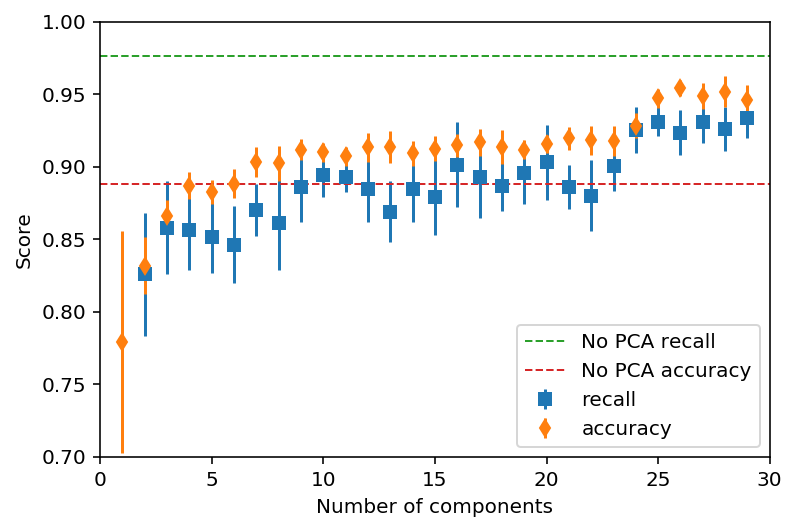

In [512]:
res_array = np.array(res)
df_results = pd.DataFrame(res_array)

# plt.plot(res_array[:, 0], res_array[:, 2], 'o', label='recall', alpha=0.2)


fig, ax = plt.subplots(1, figsize=(6, 4))

n_estimators, recall_mean = df_results.groupby(0).std().index, df_results.groupby(0).mean()[2]
n_estimators, recall_std = df_results.groupby(0).std().index, df_results.groupby(0).std()[2]
ax.errorbar(n_estimators, recall_mean, recall_std ,fmt= 's', label='recall')


n_estimators, accuracy_mean = df_results.groupby(0).std().index, df_results.groupby(0).mean()[1]
n_estimators, accuracy_std = df_results.groupby(0).std().index, df_results.groupby(0).std()[1]
ax.errorbar(n_estimators, accuracy_mean, accuracy_std ,fmt= 'd', label='accuracy')




# plt.plot(res_array[:, 0], res_array[:, 1], 'd', alpha=0.2)


ax.plot([0, 30], [no_pca[1], no_pca[1]], '--', linewidth=1, label='No PCA recall')
ax.plot([0, 30], [no_pca[2], no_pca[2]], '--', linewidth=1, label='No PCA accuracy')
ax.set_ylim([0.7, 1])
ax.set_xlim(0, 30)

ax.legend(loc=4)
ax.set(**{'xlabel':'Number of components', 'ylabel':'Score'})

# fig.savefig('../plots/score_vs_components.png', bbox_inches='tight')

In [499]:
with open('res.pkl', 'wb') as f:
    pickle.dump(res, f)

In [448]:
y_true, y_predicted = y_test, best_model['model'].predict(best_model['pca_transform'].transform(X_test))

In [449]:
confusion_matrix(y_true, y_predicted)

array([[54691,  2173],
       [   11,    87]], dtype=int64)

In [450]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_true, y_predicted)

0.924770558898855

(0, 30)

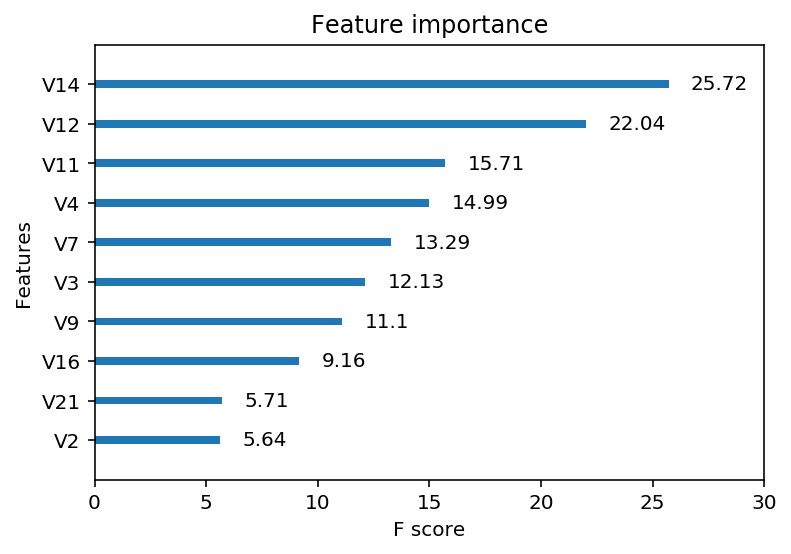

In [511]:
booster = best_model['model'].get_booster()
scores = booster.get_score(importance_type='gain')

new_map = {}
for index, feature_name in enumerate(feature_names):
    new_map[feature_name] = float(f"{scores[f'f{index}']:.2f}")

    
fig, ax = plt.subplots(1, figsize=(6, 4))
xgb.plot_importance(new_map,  max_num_features=10, ax=ax)
ax.grid('off')
ax.set_xlim(0,30)

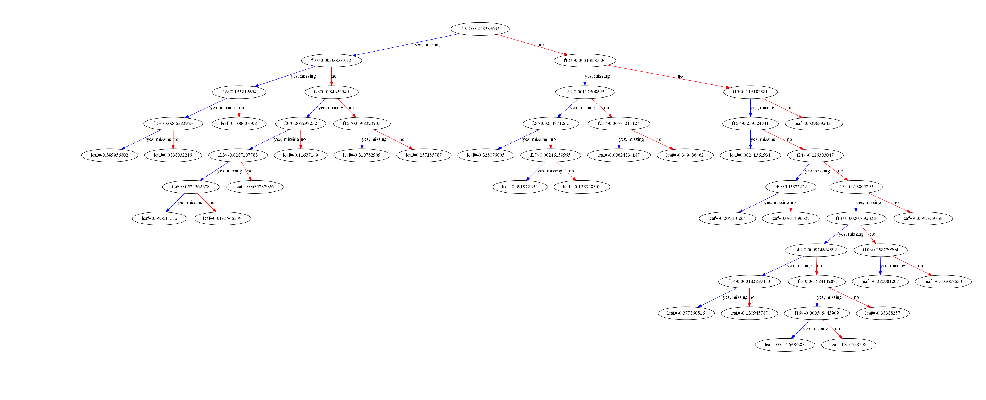

In [459]:
fig, ax = plt.subplots(1, figsize=(8, 4))
xgb.plot_tree(booster, ax = ax, num_trees=2)
fig.savefig('grap.png', dpi=1500)